<a href="https://colab.research.google.com/github/sungkwangsong/EasyOCR/blob/master/notebooks/%EC%B1%84%EC%9A%A9%EC%A0%95%EB%B3%B4_Ontology_%EC%99%80_%EB%8C%80%EC%A1%B0%ED%95%99%EC%8A%B5%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_BERT%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
HBN_RECRUITS_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/hbn-data-lake/recruitments'
HBN_ONTOLOGY_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/ontology/recruitments2'
HBN_OUTPUTS_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/outputs/ontology_bert2'
HBN_MODELS_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/models/hibrainnet/ontology_bert2'
HBN_DATASETS_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/datasets/hibrainnet'

In [3]:
!pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 8.7 MB/s eta 0:00:00


<ipython-input-5-5b5f86ad1356>:290: UserWarning: Glyph 45436 (\N{HANGUL SYLLABLE NON}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")
<ipython-input-5-5b5f86ad1356>:290: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")
<ipython-input-5-5b5f86ad1356>:290: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")
<ipython-input-5-5b5f86ad1356>:290: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")
<ipython-input-5-5b5f86ad1356>:290: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")
<ipython-input-5-5b5f86

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 884/884 [01:47<00:00,  8.22it/s]
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45436 (\N{HANGUL SYLLABLE NON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missin

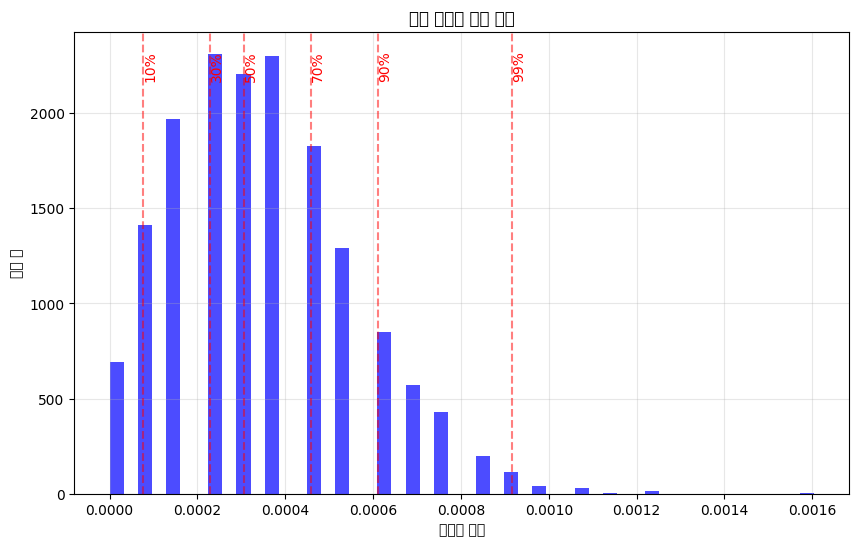

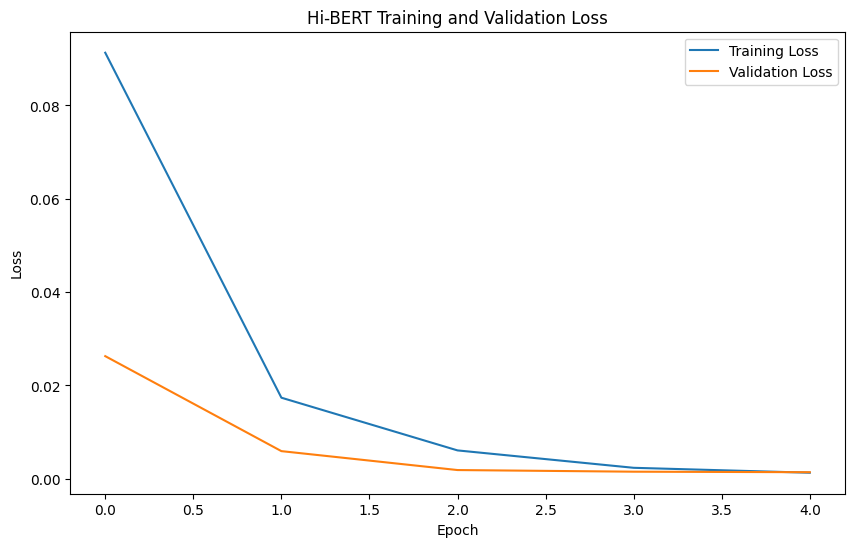

In [5]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdflib import Graph
from pathlib import Path
import logging
import random
import sys

sys.stdout.flush()

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# 설정 변수
ONTOLOGY_DIR = HBN_ONTOLOGY_DIR_PATH  # 온톨로지 파일이 있는 디렉토리
PAPERS_FILE = f"{HBN_DATASETS_DIR_PATH}/articles_total2.csv"       # 논문 데이터 파일
BATCH_SIZE = 32
MAX_LENGTH = 256
EPOCHS = 5
LR = 2e-5
MODEL_SAVE_PATH = f"{HBN_MODELS_DIR_PATH}/hi_bert_model"
BERT_MODEL_NAME = "klue/bert-base"       # 한국어 BERT 모델
EMBEDDING_DIM = 768                       # 임베딩 차원
MARGIN = 0.5                              # 트리플렛 손실의 마진

#=========================================================
# 1. 온톨로지 데이터 로드 및 전처리
#=========================================================

def load_ontology_files_with_cache(directory, cache_file="ontology_cache.pkl", use_cache=True, max_files=None):
    """캐싱을 활용한 빠른 온톨로지 로딩"""

    # 캐시 파일이 있고 사용 설정이 되어 있으면 캐시에서 로드
    if use_cache and os.path.exists(cache_file):
        logger.info(f"캐시 파일에서 온톨로지 로드 중: {cache_file}")
        import pickle
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    # 캐시가 없거나 사용하지 않는 경우 파일에서 로드
    files = list(Path(directory).glob("**/*.jsonld"))
    logger.info(f"총 {len(files)} 온톨로지 파일 발견")

    # 개발용으로 파일 수 제한 (선택 사항)
    if max_files is not None:
        files = files[:max_files]
        logger.info(f"처음 {max_files}개 파일만 사용")

    # RDFLib 그래프 생성
    g = Graph()

    # 모든 파일 파싱
    for file_path in tqdm(files, desc="온톨로지 파일 로딩 중"):
        try:
            g.parse(str(file_path), format="json-ld")
        except Exception as e:
            logger.error(f"파일 파싱 오류 {file_path}: {e}")

    logger.info(f"총 {len(g)} 트리플 로드 완료")

    # 캐시 저장
    if use_cache:
        logger.info(f"온톨로지 캐시 저장 중: {cache_file}")
        import pickle
        with open(cache_file, 'wb') as f:
            pickle.dump(g, f)

    return g

def extract_triples(graph):
    """RDFLib 그래프에서 트리플(주어-술어-목적어)을 추출합니다."""
    triples = []

    for s, p, o in graph:
        # URI에서 이름 부분만 추출 (예: http://example.org/recruitment#hasQualification -> hasQualification)
        subject = s.split('#')[-1] if '#' in s else s.split('/')[-1]
        predicate = p.split('#')[-1] if '#' in p else p.split('/')[-1]
        object_ = o.split('#')[-1] if '#' in o and isinstance(o, str) else o

        # 리터럴 값은 그대로 사용
        if isinstance(object_, str) and (object_.startswith('http://') or object_.startswith('https://')):
            object_ = object_.split('#')[-1] if '#' in object_ else object_.split('/')[-1]

        triples.append((subject, predicate, object_))

    return triples

def convert_triples_to_job_descriptions(triples):
    """트리플을 채용 설명으로 변환합니다."""
    templates = {
        "hasQualification": "{} 직무는 {} 자격증이 필요합니다.",
        "requiresCertificate": "{} 분야는 {} 자격증이 필요합니다.",
        "hasMajor": "{} 분야는 {} 전공과 관련이 있습니다.",
        "requiresMajor": "{} 분야는 {} 전공 지식이 필요합니다.",
        "hasSkill": "{} 직무는 {} 기술이 필요합니다.",
        "requiresSkill": "{} 분야는 {} 기술이 필요합니다.",
        "hasOrganization": "{} 채용은 {} 기관에서 진행합니다.",
        "hasLocation": "{} 기관은 {} 지역에 위치합니다.",
        "hasDepartment": "{} 채용은 {} 부서에서 진행합니다.",
        "hasField": "{} 부서는 {} 분야를 담당합니다.",
        "hasPositionLevel": "{} 분야는 {} 직급을 채용합니다.",
        "hasPreference": "{} 분야는 {} 우대사항이 있습니다.",
        "hasDuty": "{} 분야는 {} 업무를 담당합니다.",
        "hasMajorKeyword": "{} 전공은 {} 키워드와 관련이 있습니다.",
        "hasRequirement": "{} 분야는 {} 요구사항이 있습니다.",
        "hasRecruitmentField": "{} 채용은 {} 분야를 대상으로 합니다.",
        "hasSkillKnowledge": "{} 직무는 {} 지식/기술이 필요합니다.",
        "hasJobField": "{} 채용은 {} 직무 분야와 관련됩니다.",
        "hasJobPosting": "{} 기관은 {} 채용 공고를 게시했습니다."
    }

    job_descriptions = []

    for subject, predicate, object_ in triples:
        if predicate in templates:
            description = templates[predicate].format(subject, object_)
        else:
            description = f"{subject}는 {predicate} 관계로 {object_}와 연결됩니다."

        job_descriptions.append({
            'subject': subject,
            'predicate': predicate,
            'object': object_,
            'description': description
        })

    return job_descriptions

#=========================================================
# 2. 논문 데이터 로드 및 전처리
#=========================================================

def load_papers_from_csv(file_path):
    """주어진 CSV 파일에서 논문 데이터를 로드합니다."""
    try:
        papers = pd.read_csv(file_path)
        logger.info(f"CSV 파일에서 {len(papers)}개의 논문 데이터를 로드했습니다.")

        # 필수 컬럼 확인
        required_columns = ['title', 'abstract']
        for col in required_columns:
            if col not in papers.columns:
                logger.warning(f"필수 컬럼 '{col}'이 CSV 파일에 없습니다.")

        # 선택적 컬럼 확인 및 처리
        expected_columns = ['title', 'abstract', 'authors', 'category', 'journal_publisher', 'pub_year', 'keywords']
        for col in expected_columns:
            if col not in papers.columns:
                logger.warning(f"예상 컬럼 '{col}'이 CSV 파일에 없습니다.")

        # 결측치 확인 및 처리
        for col in papers.columns:
            missing_count = papers[col].isna().sum()
            if missing_count > 0:
                logger.warning(f"'{col}' 컬럼에 {missing_count}개의 결측치가 있습니다.")
                if col in ['title', 'abstract']:
                    # 제목이나 초록이 없는 경우 빈 문자열로 대체
                    papers[col] = papers[col].fillna('')

        # 데이터 간략히 확인
        logger.info(f"논문 데이터 샘플:\n{papers[['title']].head()}")

        return papers

    except Exception as e:
        logger.error(f"논문 데이터 로드 중 오류 발생: {e}")
        raise

def preprocess_papers_from_csv(papers_df):
    """CSV에서 로드한 논문 데이터를 전처리합니다."""
    papers_processed = papers_df.copy()

    # 결측치 처리
    papers_processed = papers_processed.fillna('')

    # 텍스트 결합: 제목, 초록, 키워드를 결합하여 전체 텍스트 생성
    papers_processed['text'] = papers_processed.apply(
        lambda x: f"제목: {x['title']} 초록: {x['abstract']} 키워드: {x['keywords']}",
        axis=1
    )

    # 카테고리 정보 추가 (있는 경우)
    if 'category' in papers_processed.columns and papers_processed['category'].any():
        papers_processed['text'] = papers_processed.apply(
            lambda x: f"{x['text']} 분야: {x['category']}",
            axis=1
        )

    # 저널 정보 추가 (있는 경우)
    if 'journal_publisher' in papers_processed.columns and papers_processed['journal_publisher'].any():
        papers_processed['text'] = papers_processed.apply(
            lambda x: f"{x['text']} 저널: {x['journal_publisher']}",
            axis=1
        )

    # 출판 연도 정보 추가 (있는 경우)
    if 'pub_year' in papers_processed.columns and papers_processed['pub_year'].any():
        papers_processed['text'] = papers_processed.apply(
            lambda x: f"{x['text']} 출판년도: {str(x['pub_year'])}",
            axis=1
        )

    logger.info(f"처리된 논문 텍스트 샘플:\n{papers_processed['text'].iloc[0][:150]}...")
    logger.info(f"전처리 후 논문 데이터: {len(papers_processed)}개")

    return papers_processed

#=========================================================
# 3. 논문과 채용정보 간의 관련성 판단
#=========================================================

def determine_paper_relevance_with_distribution(job_descriptions, papers_processed):
    """채용정보와 논문 간의 관련성을 판단하고 분포도를 확인합니다."""
    import numpy as np
    import matplotlib.pyplot as plt

    # 채용정보에서 키워드 추출
    job_keywords = set()
    for job in job_descriptions:
        # 주어, 목적어를 키워드로 사용
        job_keywords.add(job['subject'].lower())
        job_keywords.add(job['object'].lower() if isinstance(job['object'], str) else '')

    job_keywords = {k for k in job_keywords if k and len(k) > 2}  # 짧은 키워드 필터링
    logger.info(f"추출된 채용정보 키워드 수: {len(job_keywords)}")
    logger.info(f"키워드 샘플 10개: {list(job_keywords)[:10]}")

    # 각 논문에 대해 관련성 점수 계산
    relevance_scores = []

    for idx, paper in papers_processed.iterrows():
        text = paper['text'].lower()

        # 키워드 매칭 수 계산
        matching_keywords = sum(1 for kw in job_keywords if kw in text)

        # 관련성 점수 계산
        relevance_score = matching_keywords / max(1, len(job_keywords))
        relevance_scores.append(relevance_score)

    # 관련성 점수 분포 통계
    logger.info(f"\n관련성 점수 통계:")
    logger.info(f"최소값: {min(relevance_scores):.6f}")
    logger.info(f"최대값: {max(relevance_scores):.6f}")
    logger.info(f"평균값: {np.mean(relevance_scores):.6f}")
    logger.info(f"중앙값: {np.median(relevance_scores):.6f}")
    logger.info(f"표준편차: {np.std(relevance_scores):.6f}")

    # 백분위수 계산
    percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]
    percentile_values = np.percentile(relevance_scores, percentiles)

    logger.info("\n백분위수:")
    for p, v in zip(percentiles, percentile_values):
        logger.info(f"{p}%: {v:.6f}")

    # 히스토그램으로 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(relevance_scores, bins=50, alpha=0.7, color='blue')
    plt.title('논문 관련성 점수 분포')
    plt.xlabel('관련성 점수')
    plt.ylabel('논문 수')
    plt.grid(True, alpha=0.3)

    # 주요 백분위수 표시
    for p, v in zip(percentiles[1:-1:2], percentile_values[1:-1:2]):  # 10%, 30%, ... 표시
        plt.axvline(x=v, color='red', linestyle='--', alpha=0.5)
        plt.text(v, plt.ylim()[1]*0.9, f'{p}%', rotation=90, color='red')

    plt.savefig(f"{HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")
    logger.info(f"관련성 점수 분포 그래프를 저장했습니다: {HBN_OUTPUTS_DIR_PATH}/relevance_score_distribution.png")

    # 임계값 결정 (예: 하위 30%를 비관련으로)
    threshold = percentile_values[percentiles.index(30)]
    logger.info(f"\n선택한 임계값: {threshold:.6f} (30번째 백분위수)")

    # 관련성 여부 결정 및 결과 반환
    paper_relevance = []
    relevant_count = 0

    for idx, paper in papers_processed.iterrows():
        text = paper['text'].lower()
        matching_keywords = sum(1 for kw in job_keywords if kw in text)
        relevance_score = matching_keywords / max(1, len(job_keywords))
        is_relevant = relevance_score >= threshold

        if is_relevant:
            relevant_count += 1

        paper_relevance.append({
            'id': paper.get('id', idx),
            'title': paper.get('title', ''),
            'text': paper['text'],
            'relevance_score': relevance_score,
            'is_relevant': is_relevant
        })

    # 관련성 점수로 정렬
    paper_relevance.sort(key=lambda x: x['relevance_score'], reverse=True)

    logger.info(f"\n총 논문 수: {len(paper_relevance)}")
    logger.info(f"관련성 있는 논문: {relevant_count}개 ({relevant_count/len(paper_relevance)*100:.1f}%)")
    logger.info(f"관련성 없는 논문: {len(paper_relevance) - relevant_count}개")

    return paper_relevance

def determine_paper_relevance(job_descriptions, papers_processed):
    """채용정보와 논문 간의 관련성을 판단합니다."""
    # 여기서는 간단한 키워드 매칭을 사용하지만, 실제로는 더 복잡한 관련성 판단 로직이 필요할 수 있습니다

    # 채용정보에서 키워드 추출
    job_keywords = set()
    for job in job_descriptions:
        # 주어, 목적어를 키워드로 사용
        job_keywords.add(job['subject'].lower())
        job_keywords.add(job['object'].lower() if isinstance(job['object'], str) else '')

    job_keywords = {k for k in job_keywords if k and len(k) > 2}  # 짧은 키워드 필터링

    # 각 논문에 대해 관련성 판단
    paper_relevance = []

    for idx, paper in papers_processed.iterrows():
        text = paper['text'].lower()

        # 키워드 매칭 수 계산
        matching_keywords = sum(1 for kw in job_keywords if kw in text)

        # 관련성 점수 계산 (단순 예시)
        relevance_score = matching_keywords / max(1, len(job_keywords))

        paper_relevance.append({
            'id': paper.get('id', idx),
            'title': paper.get('title', ''),
            'text': paper['text'],
            'relevance_score': relevance_score,
            'is_relevant': relevance_score > 0.01  # 임의의 임계값
        })

    # 관련성 점수로 정렬
    paper_relevance.sort(key=lambda x: x['relevance_score'], reverse=True)

    logger.info(f"관련성 있는 논문: {sum(1 for p in paper_relevance if p['is_relevant'])}개")

    return paper_relevance

#=========================================================
# 4. 트리플렛 데이터셋 생성
#=========================================================

class HiBERTTripletDataset(Dataset):
    """Hi-BERT 트리플렛 데이터셋"""
    def __init__(self, job_descriptions, paper_relevance, tokenizer, max_length):
        self.job_descriptions = job_descriptions
        self.paper_relevance = paper_relevance
        self.tokenizer = tokenizer
        self.max_length = max_length

        # 관련 논문과 비관련 논문 분리
        self.relevant_papers = [p for p in paper_relevance if p['is_relevant']]
        self.irrelevant_papers = [p for p in paper_relevance if not p['is_relevant']]

        logger.info(f"트리플렛 데이터셋 생성: 채용정보 {len(self.job_descriptions)}개, "
                   f"관련 논문 {len(self.relevant_papers)}개, 비관련 논문 {len(self.irrelevant_papers)}개")

        if len(self.relevant_papers) == 0 or len(self.irrelevant_papers) == 0:
            raise ValueError("관련 논문 또는 비관련 논문이 충분하지 않습니다.")

    def __len__(self):
        # 트리플렛 수는 채용정보 수에 비례
        return len(self.job_descriptions)

    def __getitem__(self, idx):
        job = self.job_descriptions[idx % len(self.job_descriptions)]

        # 관련 논문 랜덤 선택
        pos_paper = random.choice(self.relevant_papers)

        # 비관련 논문 랜덤 선택
        neg_paper = random.choice(self.irrelevant_papers)

        # 채용정보 (앵커)
        anchor_encoding = self.tokenizer(
            job['description'],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # 관련 논문 (긍정)
        positive_encoding = self.tokenizer(
            pos_paper['text'],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # 비관련 논문 (부정)
        negative_encoding = self.tokenizer(
            neg_paper['text'],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'anchor_input_ids': anchor_encoding['input_ids'].flatten(),
            'anchor_attention_mask': anchor_encoding['attention_mask'].flatten(),
            'anchor_token_type_ids': anchor_encoding.get('token_type_ids', torch.zeros_like(anchor_encoding['input_ids'])).flatten(),

            'positive_input_ids': positive_encoding['input_ids'].flatten(),
            'positive_attention_mask': positive_encoding['attention_mask'].flatten(),
            'positive_token_type_ids': positive_encoding.get('token_type_ids', torch.zeros_like(positive_encoding['input_ids'])).flatten(),

            'negative_input_ids': negative_encoding['input_ids'].flatten(),
            'negative_attention_mask': negative_encoding['attention_mask'].flatten(),
            'negative_token_type_ids': negative_encoding.get('token_type_ids', torch.zeros_like(negative_encoding['input_ids'])).flatten(),
        }

class PaperDataset(Dataset):
    """추론용 논문 데이터셋"""
    def __init__(self, papers, tokenizer, max_length):
        self.papers = papers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.papers)

    def __getitem__(self, idx):
        paper = self.papers[idx]
        text = paper['text'] if isinstance(paper, dict) else paper

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros_like(encoding['input_ids'])).flatten(),
            'paper_id': idx
        }

#=========================================================
# 5. Hi-BERT 모델 정의
#=========================================================

class HiBERTModel(nn.Module):
    """Hi-BERT 모델 - 트리플렛 손실을 사용한 임베딩 학습"""
    def __init__(self, bert_model_name, embedding_dim=768):
        super(HiBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.embedding_projector = nn.Linear(self.bert.config.hidden_size, embedding_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # BERT 모델을 통과시켜 문장 표현 추출
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # [CLS] 토큰의 출력값 사용
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)

        # 임베딩 프로젝터를 통과
        embeddings = self.embedding_projector(pooled_output)

        # 정규화된 임베딩 반환 (코사인 유사도 계산을 위해)
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

        return normalized_embeddings

#=========================================================
# 6. 트리플렛 손실 함수
#=========================================================

class TripletContrastiveLoss(nn.Module):
    """트리플렛 대조 손실 함수"""
    def __init__(self, margin=0.5):
        super(TripletContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # 코사인 유사도
        pos_sim = torch.sum(anchor * positive, dim=1)
        neg_sim = torch.sum(anchor * negative, dim=1)

        # 트리플렛 손실 계산
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0)

        return loss.mean()

#=========================================================
# 7. 학습 함수
#=========================================================

def train_hibert_model(model, train_dataloader, val_dataloader, epochs, lr, margin=0.5):
    """Hi-BERT 모델을 학습합니다."""
    optimizer = AdamW(model.parameters(), lr=lr)

    # 학습률 스케줄러
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # 손실 함수
    criterion = TripletContrastiveLoss(margin=margin)

    # 학습 루프
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        logger.info(f"Epoch {epoch + 1}/{epochs}")

        # 훈련 모드
        model.train()
        train_loss = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            # 배치 데이터를 GPU로 이동
            anchor_input_ids = batch['anchor_input_ids'].to(device)
            anchor_attention_mask = batch['anchor_attention_mask'].to(device)
            anchor_token_type_ids = batch['anchor_token_type_ids'].to(device)

            positive_input_ids = batch['positive_input_ids'].to(device)
            positive_attention_mask = batch['positive_attention_mask'].to(device)
            positive_token_type_ids = batch['positive_token_type_ids'].to(device)

            negative_input_ids = batch['negative_input_ids'].to(device)
            negative_attention_mask = batch['negative_attention_mask'].to(device)
            negative_token_type_ids = batch['negative_token_type_ids'].to(device)

            # 그래디언트 초기화
            optimizer.zero_grad()

            # Forward 패스
            anchor_emb = model(anchor_input_ids, anchor_attention_mask, anchor_token_type_ids)
            positive_emb = model(positive_input_ids, positive_attention_mask, positive_token_type_ids)
            negative_emb = model(negative_input_ids, negative_attention_mask, negative_token_type_ids)

            # 손실 계산
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            train_loss += loss.item()

            # Backward 패스 및 최적화
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 그래디언트 클리핑
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # 검증
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                # 배치 데이터를 GPU로 이동
                anchor_input_ids = batch['anchor_input_ids'].to(device)
                anchor_attention_mask = batch['anchor_attention_mask'].to(device)
                anchor_token_type_ids = batch['anchor_token_type_ids'].to(device)

                positive_input_ids = batch['positive_input_ids'].to(device)
                positive_attention_mask = batch['positive_attention_mask'].to(device)
                positive_token_type_ids = batch['positive_token_type_ids'].to(device)

                negative_input_ids = batch['negative_input_ids'].to(device)
                negative_attention_mask = batch['negative_attention_mask'].to(device)
                negative_token_type_ids = batch['negative_token_type_ids'].to(device)

                # Forward 패스
                anchor_emb = model(anchor_input_ids, anchor_attention_mask, anchor_token_type_ids)
                positive_emb = model(positive_input_ids, positive_attention_mask, positive_token_type_ids)
                negative_emb = model(negative_input_ids, negative_attention_mask, negative_token_type_ids)

                # 손실 계산
                loss = criterion(anchor_emb, positive_emb, negative_emb)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        logger.info(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # 손실 그래프 저장
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Hi-BERT Training and Validation Loss")
    plt.legend()
    plt.savefig(f"{MODEL_SAVE_PATH}/training_loss.png")

    return model, train_losses, val_losses

#=========================================================
# 8. 임베딩 생성 및 검색 함수
#=========================================================

def generate_embeddings(model, dataloader):
    """모델을 사용하여 임베딩을 생성합니다."""
    model.eval()
    embeddings = []
    ids = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating embeddings"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            paper_ids = batch['paper_id']

            # 임베딩 생성
            embedding = model(input_ids, attention_mask, token_type_ids)

            embeddings.append(embedding.cpu().numpy())
            ids.extend(paper_ids.tolist())

    # 모든 배치의 임베딩을 하나의 배열로 결합
    embeddings = np.vstack(embeddings)
    return embeddings, ids

def search_papers(query_text, model, tokenizer, papers, paper_embeddings, top_k=5):
    """쿼리 텍스트와 관련된 상위 k개의 논문을 검색합니다."""
    # 쿼리 인코딩
    query_encoding = tokenizer(
        query_text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # 쿼리 임베딩 생성
    model.eval()
    with torch.no_grad():
        input_ids = query_encoding['input_ids'].to(device)
        attention_mask = query_encoding['attention_mask'].to(device)
        token_type_ids = query_encoding.get('token_type_ids', torch.zeros_like(input_ids)).to(device)

        query_embedding = model(input_ids, attention_mask, token_type_ids).cpu().numpy()

    # 코사인 유사도 계산
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(query_embedding, paper_embeddings)[0]

    # 상위 k개 논문 인덱스
    top_indices = similarities.argsort()[-top_k:][::-1]

    # 검색 결과 반환
    results = []
    for idx in top_indices:
        paper = papers[idx] if isinstance(papers, list) else papers.iloc[idx]
        results.append({
            'id': paper.get('id', idx) if isinstance(paper, dict) else paper.get('id', idx),
            'title': paper.get('title', '') if isinstance(paper, dict) else paper.get('title', ''),
            'similarity': similarities[idx],
            'text': paper.get('text', '') if isinstance(paper, dict) else paper.get('text', '')
        })

    return results

#=========================================================
# 9. 메인 함수
#=========================================================
def main():
    # 시작 시간 기록
    start_time = time.time()

    # 1. 온톨로지 로드 및 전처리
    logger.info("온톨로지 데이터 로드 중...")
    ontology_graph = load_ontology_files_with_cache(
        ONTOLOGY_DIR,
        cache_file=f"{HBN_OUTPUTS_DIR_PATH}/ontology_cache.pkl",
        max_files=1000,
        use_cache=True
    )

    triples = extract_triples(ontology_graph)
    job_descriptions = convert_triples_to_job_descriptions(triples)

    logger.info(f"온톨로지에서 {len(job_descriptions)}개의 채용 설명을 생성했습니다.")

    # 2. 논문 데이터 로드 및 전처리
    logger.info(f"논문 데이터 로드 중... 파일 경로: {PAPERS_FILE}")
    papers_df = load_papers_from_csv(PAPERS_FILE)
    papers_processed = preprocess_papers_from_csv(papers_df)

    # 3. 논문과 채용정보 간의 관련성 판단
    logger.info("채용정보와 논문 간의 관련성 판단 중...")
    #paper_relevance = determine_paper_relevance(job_descriptions, papers_processed)
    paper_relevance = determine_paper_relevance_with_distribution(job_descriptions, papers_processed)


    # 4. 토크나이저 설정
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

    # 5. 트리플렛 데이터셋 생성
    triplet_dataset = HiBERTTripletDataset(
        job_descriptions, paper_relevance, tokenizer, MAX_LENGTH
    )

    # 6. 학습/검증 데이터 분할
    train_size = int(0.9 * len(triplet_dataset))
    val_size = len(triplet_dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        triplet_dataset, [train_size, val_size]
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE
    )

    logger.info(f"학습 데이터: {train_size}개, 검증 데이터: {val_size}개")

    # 7. Hi-BERT 모델 초기화
    model = HiBERTModel(
        bert_model_name=BERT_MODEL_NAME,
        embedding_dim=EMBEDDING_DIM
    ).to(device)

    # 8. 모델 학습
    logger.info("Hi-BERT 모델 학습 시작...")
    model, train_losses, val_losses = train_hibert_model(
        model, train_dataloader, val_dataloader, EPOCHS, LR, MARGIN
    )

    # 9. 모델 저장
    logger.info(f"모델 저장 중: {MODEL_SAVE_PATH}")
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)

    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/model.pt")

    # 10. 논문 임베딩 데이터셋 생성
    paper_dataset = PaperDataset(
        [{'text': p['text']} for p in paper_relevance], tokenizer, MAX_LENGTH
    )
    paper_dataloader = DataLoader(
        paper_dataset, batch_size=BATCH_SIZE
    )

    # 11. 논문 임베딩 생성
    logger.info("논문 임베딩 생성 중...")
    paper_embeddings, paper_ids = generate_embeddings(model, paper_dataloader)

    # 12. 논문 정보 및 임베딩 저장
    paper_info_list = []
    for i, paper in enumerate(paper_relevance):
        paper_info_list.append({
            'id': paper.get('id', i),
            'title': paper.get('title', ''),
            'relevance_score': paper.get('relevance_score', 0)
        })

    paper_info_df = pd.DataFrame(paper_info_list)
    paper_info_df.to_csv(f"{MODEL_SAVE_PATH}/paper_info.csv", index=False)

    # 임베딩 저장
    np.save(f"{MODEL_SAVE_PATH}/paper_embeddings.npy", paper_embeddings)

    # 13. 채용정보 임베딩 데이터셋 생성 및 임베딩 저장
    job_dataset = PaperDataset(
        [{'text': job['description']} for job in job_descriptions], tokenizer, MAX_LENGTH
    )
    job_dataloader = DataLoader(
        job_dataset, batch_size=BATCH_SIZE
    )

    logger.info("채용정보 임베딩 생성 중...")
    job_embeddings, job_ids = generate_embeddings(model, job_dataloader)
    np.save(f"{MODEL_SAVE_PATH}/job_embeddings.npy", job_embeddings)

    # 14. 총 소요 시간 계산
    total_time = time.time() - start_time
    logger.info(f"전체 과정 완료! 총 소요 시간: {total_time:.2f}초 ({total_time/60:.2f}분)")

    # 15. 검색 예제 실행
    logger.info("검색 예제 실행...")
    test_query = "인공지능 분야의 전문가 채용"
    search_results = search_papers(
        test_query, model, tokenizer, paper_relevance, paper_embeddings, top_k=5
    )

    logger.info(f"검색 결과 - 쿼리: '{test_query}'")
    for i, result in enumerate(search_results):
        logger.info(f"결과 {i+1}: {result['title']} (유사도: {result['similarity']:.4f})")

    # 16. 상호 검색 예제 (논문으로 관련 채용정보 찾기)
    if len(paper_relevance) > 0:
        sample_paper = paper_relevance[0]['text']
        logger.info(f"논문으로 관련 채용정보 찾기 - 샘플 논문: '{sample_paper[:100]}...'")

        # 논문 임베딩 생성
        paper_encoding = tokenizer(
            sample_paper,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        with torch.no_grad():
            input_ids = paper_encoding['input_ids'].to(device)
            attention_mask = paper_encoding['attention_mask'].to(device)
            token_type_ids = paper_encoding.get('token_type_ids', torch.zeros_like(input_ids)).to(device)

            paper_embedding = model(input_ids, attention_mask, token_type_ids).cpu().numpy()

        # 채용정보와의 유사도 계산
        from sklearn.metrics.pairwise import cosine_similarity
        similarities = cosine_similarity(paper_embedding, job_embeddings)[0]

        # 상위 5개 채용정보 인덱스
        top_indices = similarities.argsort()[-5:][::-1]

        # 결과 출력
        logger.info("관련 채용정보:")
        for i, idx in enumerate(top_indices):
            job_idx = job_ids[idx]
            job = job_descriptions[job_idx]
            logger.info(f"결과 {i+1}: {job['description']} (유사도: {similarities[idx]:.4f})")

if __name__ == "__main__":
    main()


In [6]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import logging
from tqdm import tqdm

MODEL_SAVE_PATH = f"{HBN_MODELS_DIR_PATH}/hi_bert_model"

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Hi-BERT 모델 정의 (원본 코드에서 가져옴)
class HiBERTModel(nn.Module):
    """Hi-BERT 모델 - 트리플렛 손실을 사용한 임베딩 학습"""
    def __init__(self, bert_model_name, embedding_dim=768):
        super(HiBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.embedding_projector = nn.Linear(self.bert.config.hidden_size, embedding_dim)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # BERT 모델을 통과시켜 문장 표현 추출
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # [CLS] 토큰의 출력값 사용
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)

        # 임베딩 프로젝터를 통과
        embeddings = self.embedding_projector(pooled_output)

        # 정규화된 임베딩 반환 (코사인 유사도 계산을 위해)
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

        return normalized_embeddings

# 추론용 데이터셋 클래스 (원본 코드에서 가져옴)
class PaperDataset(Dataset):
    """추론용 논문 데이터셋"""
    def __init__(self, papers, tokenizer, max_length):
        self.papers = papers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.papers)

    def __getitem__(self, idx):
        paper = self.papers[idx]
        text = paper['text'] if isinstance(paper, dict) else paper

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros_like(encoding['input_ids'])).flatten(),
            'paper_id': idx
        }

# 새로운 클래스: 전문가 매칭 시스템
class ExpertMatchingSystem:
    def __init__(self, model_path, bert_model_name="klue/bert-base", embedding_dim=768, max_length=256):
        """전문가 매칭 시스템 초기화

        Args:
            model_path: 사전 학습된 Hi-BERT 모델 경로
            bert_model_name: 기본 BERT 모델 이름
            embedding_dim: 임베딩 차원
            max_length: 최대 시퀀스 길이
        """
        self.model_path = model_path
        self.bert_model_name = bert_model_name
        self.embedding_dim = embedding_dim
        self.max_length = max_length

        # 토크나이저 로드
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)

        # 모델 로드
        self.model = self._load_model()

        # 논문 임베딩과 정보 로드
        self.paper_embeddings = np.load(f"{model_path}/paper_embeddings.npy")
        self.paper_info = pd.read_csv(f"{model_path}/paper_info.csv")

        # 저자 정보 로드 (있는 경우)
        try:
            self.author_info = pd.read_csv(f"{model_path}/author_info.csv")
            self.has_author_info = True
            logger.info("저자 정보를 로드했습니다.")
        except:
            logger.warning("저자 정보 파일이 없습니다. 논문 제목만 사용합니다.")
            self.has_author_info = False

    def _load_model(self):
        """사전 학습된 모델을 로드합니다."""
        model = HiBERTModel(self.bert_model_name, self.embedding_dim).to(device)
        model.load_state_dict(torch.load(f"{self.model_path}/model.pt", map_location=device))
        model.eval()
        logger.info("모델을 로드했습니다.")
        return model

    def _get_query_embedding(self, query_text):
        """쿼리 텍스트의 임베딩을 생성합니다."""
        query_encoding = self.tokenizer(
            query_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        with torch.no_grad():
            input_ids = query_encoding['input_ids'].to(device)
            attention_mask = query_encoding['attention_mask'].to(device)
            token_type_ids = query_encoding.get('token_type_ids', torch.zeros_like(input_ids)).to(device)

            query_embedding = self.model(input_ids, attention_mask, token_type_ids).cpu().numpy()

        return query_embedding

    def search_papers(self, query_text, top_k=5):
        """쿼리 텍스트와 관련된 상위 k개의 논문을 검색합니다."""
        query_embedding = self._get_query_embedding(query_text)

        # 코사인 유사도 계산
        similarities = cosine_similarity(query_embedding, self.paper_embeddings)[0]

        # 상위 k개 논문 인덱스
        top_indices = similarities.argsort()[-top_k:][::-1]

        # 검색 결과 반환
        results = []
        for idx in top_indices:
            paper_info = self.paper_info.iloc[idx]
            results.append({
                'id': paper_info.get('id', idx),
                'title': paper_info.get('title', 'Unknown Title'),
                'similarity': similarities[idx],
                'relevance_score': paper_info.get('relevance_score', 0),
            })

        return results

    def find_experts(self, query_text, top_k=5, top_authors=3):
        """채용정보 쿼리를 통해 관련 논문을 찾고, 그 논문의 저자들을 전문가로 추천합니다.

        Args:
            query_text: 채용정보 쿼리 텍스트
            top_k: 검색할 상위 논문 수
            top_authors: 추천할 상위 저자 수

        Returns:
            논문 및 전문가 추천 정보
        """
        # 관련 논문 검색
        relevant_papers = self.search_papers(query_text, top_k)

        # 저자 정보가 있으면 저자 추출
        if self.has_author_info:
            # 저자별 논문 수와 평균 유사도 계산
            author_scores = {}

            for paper in relevant_papers:
                paper_id = paper['id']
                paper_authors = self.author_info[self.author_info['paper_id'] == paper_id]

                for _, author_row in paper_authors.iterrows():
                    author_name = author_row['author_name']

                    if author_name not in author_scores:
                        author_scores[author_name] = {
                            'count': 0,
                            'total_similarity': 0,
                            'papers': []
                        }

                    author_scores[author_name]['count'] += 1
                    author_scores[author_name]['total_similarity'] += paper['similarity']
                    author_scores[author_name]['papers'].append({
                        'title': paper['title'],
                        'similarity': paper['similarity']
                    })

            # 평균 유사도 계산 및 정렬
            experts = []
            for author_name, scores in author_scores.items():
                avg_similarity = scores['total_similarity'] / scores['count']
                experts.append({
                    'name': author_name,
                    'paper_count': scores['count'],
                    'avg_similarity': avg_similarity,
                    'papers': scores['papers'][:3]  # 최대 3개의 논문만 표시
                })

            # 유사도 기준으로 정렬
            experts.sort(key=lambda x: x['avg_similarity'], reverse=True)
            experts = experts[:top_authors]

            return {
                'query': query_text,
                'relevant_papers': relevant_papers,
                'experts': experts
            }
        else:
            # 저자 정보가 없으면 논문만 반환
            return {
                'query': query_text,
                'relevant_papers': relevant_papers,
                'message': "저자 정보가 없어 전문가 추천이 불가능합니다."
            }

    def create_author_info_from_papers(self, papers_csv, output_file=None):
        """논문 CSV 파일에서 저자 정보를 추출합니다.

        Args:
            papers_csv: 논문 정보가 있는 CSV 파일 경로
            output_file: 저장할 파일 경로 (기본값: model_path/author_info.csv)
        """
        if output_file is None:
            output_file = f"{self.model_path}/author_info.csv"

        # 논문 파일 로드
        papers_df = pd.read_csv(papers_csv)

        # 저자 정보 추출
        author_data = []

        for _, paper in papers_df.iterrows():
            paper_id = paper.get('id', None)
            if paper_id is None:
                paper_id = paper.name  # 인덱스를 ID로 사용

            title = paper.get('title', 'Unknown Title')
            authors = paper.get('authors', '')

            # 저자 정보가 있는 경우
            if authors and isinstance(authors, str):
                # 저자 분리 (쉼표, 세미콜론, 'and' 등으로 구분될 수 있음)
                for separator in [',', ';', ' and ']:
                    if separator in authors:
                        author_list = [a.strip() for a in authors.split(separator)]
                        break
                else:
                    author_list = [authors.strip()]

                for author_name in author_list:
                    if author_name:
                        author_data.append({
                            'paper_id': paper_id,
                            'paper_title': title,
                            'author_name': author_name
                        })

        # 데이터프레임 생성 및 저장
        author_df = pd.DataFrame(author_data)
        author_df.to_csv(output_file, index=False)

        logger.info(f"저자 정보를 생성하여 {output_file}에 저장했습니다.")
        logger.info(f"총 {len(author_df)}개의 저자 정보를 추출했습니다.")

        # 메모리에 로드
        self.author_info = author_df
        self.has_author_info = True

        return author_df


def main():
    """메인 함수"""
    # 변수 직접 설정
    MODEL_PATH = f"{HBN_MODELS_DIR_PATH}/hi_bert_model"  # 학습된 모델이 저장된 경로
    PAPERS_CSV = f"{HBN_DATASETS_DIR_PATH}/articles_total.csv"  # 논문 데이터 CSV

    # 검색할 채용정보 쿼리 예시
    queries = [
        "인공지능 분야 전문가 채용, 딥러닝 및 머신러닝 경험자 우대",
        "빅데이터 분석 전문가, 통계 분석 및 데이터 시각화 경험자",
        "자연어처리 및 기계번역 전문가 채용, 한국어-영어 번역 모델 개발 경험자 우대"
    ]

    # 전문가 매칭 시스템 초기화
    print("=== 전문가 매칭 시스템 초기화 중... ===")
    expert_system = ExpertMatchingSystem(MODEL_PATH)

    # 저자 정보가 없는 경우 생성
    if not expert_system.has_author_info:
        print(f"저자 정보 파일이 없습니다. {PAPERS_CSV}에서 저자 정보를 추출합니다.")
        expert_system.create_author_info_from_papers(PAPERS_CSV)

    # 각 쿼리에 대해 전문가 검색 실행
    for i, query in enumerate(queries):
        print(f"\n\n=== 검색 {i+1}: {query} ===")
        results = expert_system.find_experts(query, top_k=5, top_authors=3)

        print(f"쿼리: {results['query']}")

        print("\n[관련 논문]")
        for j, paper in enumerate(results['relevant_papers']):
            print(f"{j+1}. {paper['title']} (유사도: {paper['similarity']:.4f})")

        if 'experts' in results:
            print("\n[추천 전문가]")
            for j, expert in enumerate(results['experts']):
                print(f"{j+1}. {expert['name']} - 논문 {expert['paper_count']}개, 평균 유사도: {expert['avg_similarity']:.4f}")
                print("   주요 논문:")
                for k, paper in enumerate(expert['papers']):
                    print(f"   - {paper['title']} (유사도: {paper['similarity']:.4f})")
        else:
            print(f"\n{results['message']}")

    # 사용자 정의 쿼리 입력 받기
    # custom_query = input("\n\n검색할 채용정보를 입력하세요 (종료하려면 'q' 입력): ")
    # while custom_query.lower() != 'q':
    #     results = expert_system.find_experts(custom_query, top_k=5, top_authors=3)

    #     print(f"\n쿼리: {results['query']}")

    #     print("\n[관련 논문]")
    #     for j, paper in enumerate(results['relevant_papers']):
    #         print(f"{j+1}. {paper['title']} (유사도: {paper['similarity']:.4f})")

    #     if 'experts' in results:
    #         print("\n[추천 전문가]")
    #         for j, expert in enumerate(results['experts']):
    #             print(f"{j+1}. {expert['name']} - 논문 {expert['paper_count']}개, 평균 유사도: {expert['avg_similarity']:.4f}")
    #             print("   주요 논문:")
    #             for k, paper in enumerate(expert['papers']):
    #                 print(f"   - {paper['title']} (유사도: {paper['similarity']:.4f})")
    #     else:
    #         print(f"\n{results['message']}")

    #     custom_query = input("\n\n검색할 채용정보를 입력하세요 (종료하려면 'q' 입력): ")

    # print("\n프로그램을 종료합니다.")


if __name__ == "__main__":
    main()

=== 전문가 매칭 시스템 초기화 중... ===


=== 검색 1: 인공지능 분야 전문가 채용, 딥러닝 및 머신러닝 경험자 우대 ===
쿼리: 인공지능 분야 전문가 채용, 딥러닝 및 머신러닝 경험자 우대

[관련 논문]
1. 인공지능 기반의 자동화된 통합보안관제시스템 모델 연구 (유사도: 0.9949)
2. 인공지능 기반 밭작물 생산량 모니터링 기술 동향 (유사도: 0.9944)
3. 빅데이터를 위한 데이터 품질 평가 방법에 대한 연구 (유사도: 0.9943)
4. 4차-5차산업혁명기술 개발을 위한 인공지능 알고리즘의 활용 대상과 범위 분석 (유사도: 0.9942)
5. 4차-5차산업혁명기술 개발을 위한 인공지능 알고리즘의 활용 대상과 범위 분석 (유사도: 0.9942)

[추천 전문가]
1. 남원식(극동대학교) - 논문 1개, 평균 유사도: 0.9949
   주요 논문:
   - 인공지능 기반의 자동화된 통합보안관제시스템 모델 연구 (유사도: 0.9949)
2. 조한진(극동대학교) - 논문 1개, 평균 유사도: 0.9949
   주요 논문:
   - 인공지능 기반의 자동화된 통합보안관제시스템 모델 연구 (유사도: 0.9949)
3. 최지원(경상국립대학교) - 논문 1개, 평균 유사도: 0.9944
   주요 논문:
   - 인공지능 기반 밭작물 생산량 모니터링 기술 동향 (유사도: 0.9944)


=== 검색 2: 빅데이터 분석 전문가, 통계 분석 및 데이터 시각화 경험자 ===
쿼리: 빅데이터 분석 전문가, 통계 분석 및 데이터 시각화 경험자

[관련 논문]
1. 스마트 플랜트를 위한 빅데이터 및 AutoML 플랫폼 개발 (유사도: 0.9917)
2. 스마트 플랜트를 위한 빅데이터 및 AutoML 플랫폼 개발 (유사도: 0.9917)
3. 스마트 플랜트를 위한 빅데이터 및 AutoML 플랫폼 개발 (유사도: 0.9917)
4. 빅데이터 기반 컴퓨터 언어 교육에 대한 선호도 및 시각화 (유사도: 0.9917)
5. 빅데이터 기반 컴퓨터 언어 교육에 대한